# Thermal expansion via QHA

This tutorial explains how to calculate thermal expansion of solids using quasi-harmonic approximation. Is uses <a href="https://github.com/efiminem/asexecutor">asexecutor</a>, which is a convenient python library to execute ASE calculators on supercomputers. Other examples are also available in the link. You can run the following cell to install it:

In [ ]:
# !pip install asexecutor -y

If you want to visualise structures in your notebook, you need to install <a href="https://github.com/arose/nglview">nglview</a>. In this case uncomment and run the cell below and restart your Jupyter session:

In [ ]:
# !conda install -c conda-forge nglview -y
# !jupyter nbextension enable nglview --py --sys-prefix

In order to calculate thermal expansion we use quasi-harmonic approximation (QHA) where Helmholtz free energy $F$ of a crystal is written as harmonic for each particular volume:<br><br>
$$F_{\text{QHA}} (T, V) = U(V) + F_{\text{vib}} (T, V),$$<br>
where $U(V)$ is a zero-temperature internal energy of a crystal without vibrational contribution, which is usually obtained via single point DFT calculations. The vibrational contribution can be written as
$$F_{\text{vib}} (T, V) = \sum \frac12 \hbar \omega_{k, i} + \sum k_B T \ln [1- \exp(-\hbar \omega_{k, i}/k_B T)].$$<br>
By applying a Legendre transform, it is possible to obtain the Gibbs free energy $G(T, P)$ of the system as a function of temperature and pressure:<br><br>
$$G_{\text{QHA}}(T, P) = \min_V [F_{\text{QHA}} (T, V) + pV].$$<br>
The volume at which $F_{\text{QHA}} (T, V) + pV$ is minimized will be the equilibrium volume $V_\text{eq} (T, P)$. A volumetric thermal expansion coefficient $\alpha_V(T, P)$ can be defined as:<br>
$$\alpha_V(T,P) = \frac{1}{V_\text{eq} (T, P)} \left(\frac{\partial V_\text{eq} (T, P)}{\partial T}\right)_p.$$<br>
For nearly isotropic crystals, a linear thermal expansion coefficient $\alpha_L(T, P)$ is often considered which is $\alpha_L(T, P) = \alpha_V(T, P)/3$.

In [1]:
import os
import ase
import json
import numpy as np
from ase import eos
from ase.visualize.ngl import view_ngl
from ase.calculators.vasp import Vasp2
from getpass import getpass
import pylab as plt
from asexecutor import Executorfrom asexecutor.units import KiB, MiB, GiB

In [2]:
INITIAL_POSCAR_PATH = "Cr3Si.POSCAR"
initial_structure = ase.io.read(INITIAL_POSCAR_PATH, format="vasp")
formula = ase.formula.formula_hill(initial_structure.numbers, empirical=False)
composition = ase.formula.formula_hill(initial_structure.numbers, empirical=True)
print("Formula: {}".format(formula))
print("Composition: {}".format(composition))
print("Volume: {:.6f}".format(initial_structure.get_volume()))

Formula: Cr6Si2
Composition: Cr3Si
Volume: 92.273838


In [3]:
# Here we are going to store calculations
PATH_PREFIX = composition
os.makedirs(PATH_PREFIX + "/final", exist_ok=True)

In [4]:
view_ngl(initial_structure, w=400, h=400)

_ColormakerRegistry()

## 0. Setup calculations

Connect to the cluster:

In [5]:
ex = Executor()
ex.connect(host="8.8.8.8", user="username", password=getpass())

········


We need to have local copy of pseudopotentials:

In [6]:
# In this example POTCAR_Lib is in your home directory on cluster.
# The cell downloads it and sets the VASP_PP_PATH environment variable.
# If you already have it on your computer just put the appropriate path.
#
# Note: it is possible, that you will need to change the structure of your
# POTCAR folder in order to satisfy ASE requirements. It should be as follows,
# with each element in separate folder:
#
# LDA:  VASP_PP_PATH/potpaw/
# PBE:  VASP_PP_PATH/potpaw_PBE/
# PW91: VASP_PP_PATH/potpaw_GGA/
#

if "VASP_PP_PATH" not in os.environ:
    os.environ["VASP_PP_PATH"] = ex.get("POTCAR_Lib")

## 1. Relax the initial structure

We relax the structure with a high accuracy. If your initial structure is bad you probably need additional relaxation with weaker setup.

In [7]:
vasp_opt = Vasp2(directory=PATH_PREFIX + "/relax", xc="PBE", prec="accurate",
                 isif=3, ibrion=2, encut=600, ediff=1e-7,
                 ediffg=-1e-6, nsw=100, ismear=0, sigma=0.1,
                 lcharg=False, lreal=False, lwave=False, addgrid=True,
                 gamma=True, npar=4, kpts=(11, 11, 11))

# we wrap the ase.calculator to be executed on cluster
vasp_opt = ex.wrap_calc(vasp_opt, name="relax", queue="lenovo", njobs=8)

In [8]:
optimized_structure = initial_structure.copy()
optimized_structure.calc = vasp_opt

In [ ]:
# load results
# vasp_opt.read_json(os.path.join(vasp_opt.directory, "vasp_opt.json"))

In [12]:
# update this cell to check the status of calculation
vasp_opt.calculate(optimized_structure)

In [13]:
# save results
vasp_opt.write_json("vasp_opt.json")

In [14]:
# if forces are bigger than 10-4 we need further relaxation
optimized_structure.get_forces()

array([[ 0., -0., -0.],
       [ 0., -0.,  0.],
       [ 0.,  0., -0.],
       [ 0.,  0.,  0.],
       [-0.,  0.,  0.],
       [ 0., -0., -0.],
       [-0.,  0.,  0.],
       [-0.,  0.,  0.]])

## 2. Relax the structure for different volumes

In order to correctly account for thermal expansion you need to optimize positions of ions at each volume because it is how a real structure would expand. Here you have two options:
<ul>
    <li>Optimize the ions and cell for each volume (ISIF=4 flag in VASP). It can be computationally more 
    demanding because it can break the symmetry of the crystal therefore increasing the number of irreducible 
    k-points, but more realistic. If you have imaginary frequencies in your band structure plot, 
    you should stick with this option.</li>
    <li>Optimize only the ions for each volume (ISIF=2 flag in VASP). It is computationally cheaper but 
    less realistic. You should only use this option in the case of time constraints.</li>
</ul>

In [15]:
vcells = []
vasp_opts_v = []
scale_factors = np.arange(0.95, 1.05, 0.01)
scale_left = -np.sum(scale_factors < 1)

for idx, factor in enumerate(scale_factors):
    vcell = optimized_structure.copy()
    vcell.set_cell(optimized_structure.cell * factor, scale_atoms = True)
    vcells.append(vcell)
    step = scale_left + idx
    vasp_opt_v = Vasp2(directory=PATH_PREFIX + "/relax-v/step-" + str(step), xc="PBE", prec="accurate",
                     isif=4, ibrion=2, encut=600, ediff=1e-7,
                     ediffg=-1e-6, nsw=100, ismear=0, sigma=0.1,
                     lcharg=False, lreal=False, lwave=False, addgrid=True,
                     gamma=True, npar=4, kpts=(11, 11, 11))
    vasp_opt_v = ex.wrap_calc(vasp_opt_v, name="relax-v", queue="lenovo", njobs=8)
    vcell.calc = vasp_opt_v
    vasp_opts_v.append(vasp_opt_v)

In [ ]:
# load results
# for vasp_opt_v in vasp_opts_v:
#     vasp_opt_v.read_json(os.path.join(vasp_opt_v.directory, "vasp_opt_v.json"))

In [17]:
# update this cell to check the status of calculations
for vcell, vasp_opt_v in zip(vcells, vasp_opts_v):
    vasp_opt_v.calculate(vcell)

In [18]:
# save results
for vasp_opt_v in vasp_opts_v:
    vasp_opt_v.write_json("vasp_opt_v.json")

## 3. Energy-volume plot

We need to calculate the total energy for each volume. In principle, we already know energies from the previous step but this is more accurate calculation using tetrahedron method with Bloechl corrections (ISMEAR = -5 flag in VASP). Moreover, we get rid of possible Pullay stresses.

In [19]:
vasp_energies = []

for idx, vcell in enumerate(vcells):
    step = scale_left + idx
    vasp_energy = Vasp2(directory=PATH_PREFIX + "/energy/step-" + str(step) , xc="PBE", prec="accurate",
                        ibrion=-1, encut=600, ediff=1e-7, ismear=-5, sigma=0.1,
                        lcharg=False, lreal=False, lwave=False, addgrid=True,
                        gamma=True, npar=4, kpts=(11, 11, 11))
    vasp_energy = ex.wrap_calc(vasp_energy, name="energy", queue="lenovo", njobs=8)
    vcell.calc = vasp_energy
    vasp_energies.append(vasp_energy)

In [ ]:
# load results
# for vasp_energy in vasp_energies:
#     vasp_energy.read_json(os.path.join(vasp_energy.directory, "vasp_energy.json"))

In [23]:
# update this cell to check the status of calculations

energies = []
volumes = []

for vcell in vcells:
    energies.append(vcell.get_potential_energy())
    volumes.append(vcell.get_volume())

In [24]:
# save results
for vasp_energy in vasp_energies:
    vasp_energy.write_json("vasp_energy.json")

In [25]:
vinet = ase.eos.EquationOfState(volumes, energies, eos="vinet")
v0, e0, B = vinet.fit()
print("Optimal volume: {} (A^3)".format(v0))
print("Minimum total energy: {} (eV)".format(e0))
print("Bulk modulus: {} (GPa)".format(B * 1e24 / ase.units.kJ))

Optimal volume: 91.20629047785727 (A^3)
Minimum total energy: -70.63038744236225 (eV)
Bulk modulus: 249.74184654823085 (GPa)


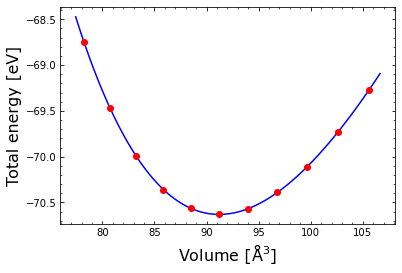

In [26]:
v = np.linspace(0.99*volumes[0], 1.01*volumes[-1], 100)
e = vinet.func(v, *vinet.eos_parameters)
plt.ylabel("Total energy [eV]", fontsize=16, fontfamily="Verdana")
plt.xlabel("Volume [Å$^3$]", fontsize=16, fontfamily="Verdana")
plt.plot(v, e, c='b')
plt.plot(volumes, energies, 'o', c="r")
plt.tick_params(which="both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/energy_volume.jpeg", dpi=300)

In [27]:
with open(PATH_PREFIX + "/final/e-v.dat", "w") as f:
    for energy, volume in zip(energies, volumes):
        f.write("{:.8f}\t{:.8f}\n".format(volume, energy))

## 4. Calculate forces for each volume

In [28]:
from phonopy import Phonopy, PhonopyQHA
from phonopy.interface.vasp import VasprunxmlExpat
from phonopy.qha.electron import ElectronFreeEnergy
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

First we create supercells with displacements for each volume. If point symmetry group of your supercell will 
be different from those of primitive cell you will get a warning.

In [74]:
vasp_forces_with_disps = [] # VASP2 calculators
scells_with_disps = [] # Supercells with displacements
phs = [] # Phonopy objects

for idx, vcell in enumerate(vcells):
    ph = Phonopy(vcell.copy(), supercell_matrix=np.diag([3, 3, 3])) # 3x3x3 supercell
    ph.generate_displacements(distance=0.01)
    phs.append(ph)
    
    vasp_forces = []
    scells = ph.get_supercells_with_displacements()
    for jdx, scell in enumerate(scells):
        step = scale_left + idx
        scells[jdx] = ase.Atoms(symbols=scell.get_chemical_symbols(),
                                scaled_positions=scell.get_scaled_positions(),
                                cell=scell.get_cell(), pbc=True)
        vasp_forces_this = Vasp2(directory=PATH_PREFIX + "/forces/step-" + str(step) + "/disp-" + str(jdx + 1).zfill(3),
                                 xc="PBE", prec="accurate", ibrion=-1, encut=500,
                                 ediff=1e-7, ismear=0, sigma=0.1,
                                 lcharg=False, lreal=False, lwave=False, addgrid=True,
                                 gamma=True, npar=4, kpts=(5, 5, 5))
        vasp_forces_this = ex.wrap_calc(vasp_forces_this, name="phonons-" + str(step),
                                        queue="lenovo", njobs=40)
        scells[jdx].calc = vasp_forces_this
        vasp_forces.append(vasp_forces_this)
        
    vasp_forces_with_disps.append(vasp_forces)
    scells_with_disps.append(scells)

In [ ]:
# load results
# for vasp_forces in vasp_forces_with_disps:
#     for vasp_forces_this in vasp_forces:
#         vasp_forces_this.read_json(os.path.join(vasp_forces_this.directory, "vasp_forces.json"))

Next we calculate forces for each volume and displacement. <br>
<b>WARNING</b>: this calculation can be heavy.

In [97]:
# update this cell to check the status of calculations

forces_with_disps = []

for scell_with_disps in scells_with_disps:
    force_set = []
    for scell in scell_with_disps:
        force_set.append(scell.get_forces())
    forces_with_disps.append(force_set)

In [98]:
# save results
for vasp_forces in vasp_forces_with_disps:
    for vasp_forces_this in vasp_forces:
        vasp_forces_this.write_json("vasp_forces.json")

Drift force is the sum of forces in a supercell. Due to translational symmetry, it is expected to be zero. 
To enforce this condition we substract the drift force divided by the number of atoms from each force.

In [99]:
for force_set in forces_with_disps:
    for forces in force_set:
        drift_force = forces.sum(axis=0)
        forces -= drift_force/forces.shape[0]

## 5. Calculate thermal properties for each volume

In [100]:
for ph, force_set in zip(phs, forces_with_disps):
    ph.produce_force_constants(forces=force_set)
    ph.run_mesh([48, 48, 48]) # q-point mesh

In [101]:
# Density of states

ph = phs[0] # structure with the smallest volume
ph.run_total_dos(use_tetrahedron_method=True)
dos_dict = ph.get_total_dos_dict()
frequency_points = dos_dict["frequency_points"]
total_dos = dos_dict["total_dos"]

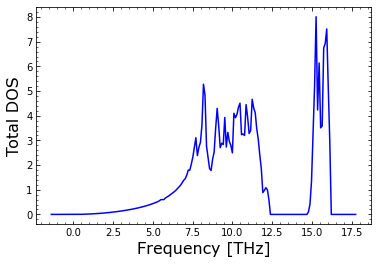

In [102]:
plt.ylabel("Total DOS", fontsize=16, fontfamily="Verdana")
plt.xlabel("Frequency [THz]", fontsize=16, fontfamily="Verdana")
plt.plot(frequency_points, total_dos, c="b")
plt.tick_params(which="both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/dos.jpeg", dpi=300)

In [103]:
# Band structure

path = [[[0, 0, 0], [0.5, 0, 0.5], [0.625, 0.25, 0.625]],
        [[0.375, 0.375, 0.75], [0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.25, 0.75]]]

labels = ["$\\Gamma$", "X", "U/K", "$\\Gamma$", "L", "W"]
qpoints, path_connections = get_band_qpoints_and_path_connections(path, npoints=50)

ph.run_band_structure(qpoints, path_connections=path_connections, labels=labels)
band_dict = ph.get_band_structure_dict()
distances = np.array(band_dict["distances"])
nbands = len(band_dict["frequencies"][0][0])
frequencies = np.array(band_dict["frequencies"]).reshape(-1, nbands).T

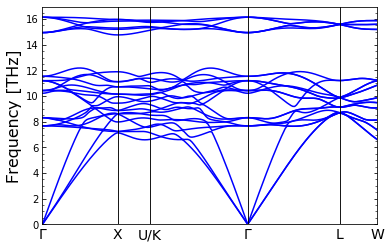

In [104]:
plt.xlim(0, max(distances.flatten()))
for i in range(nbands):
    plt.plot(distances.flatten(), frequencies[i], c='b')
    
kpts = []
for idx, distance in enumerate(distances):
    if idx==0:
        kpts.append(distance[0])
    kpts.append(distance[-1])
    if idx+1 != len(distances):
        plt.axvline(distance[-1], color='k', linewidth=0.9)
plt.ylim(bottom=min(frequencies.flatten()))
plt.ylabel("Frequency [THz]", fontsize=16, fontfamily="Verdana")
plt.tick_params(which="both", right=True, bottom=False, direction="in")
plt.xticks(kpts, labels, fontsize=14)
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/band_structure.jpeg", dpi=300)

## 6. Calculate thermal expansion

In [105]:
temperatures = []
free_energies = []
entropies = []
heat_capacities = []

for ph in phs:
    ph.run_thermal_properties(t_min=0, t_max=1000, t_step=10)
    tp_dict = ph.get_thermal_properties_dict()
    temperatures.append(tp_dict["temperatures"])
    free_energies.append(tp_dict["free_energy"])
    entropies.append(tp_dict["entropy"])
    heat_capacities.append(tp_dict["heat_capacity"])
    
temperatures = tp_dict["temperatures"]

In [106]:
qha = PhonopyQHA(volumes, energies, temperatures=temperatures, free_energy=np.transpose(free_energies),
                 cv=np.transpose(heat_capacities), entropy=np.transpose(entropies), eos='vinet')
helmholtz_volume = np.array(qha.get_helmholtz_volume())
thermal_expansion = np.array(qha.get_thermal_expansion())
volume_temperature = np.array(qha.get_volume_temperature())
gruneisen_temperature = np.array(qha.get_gruneisen_temperature())

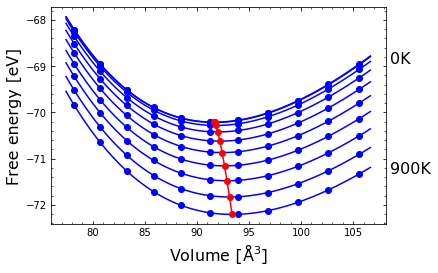

In [107]:
step = 10
qha_parameters = qha._qha._equiv_parameters
for idx, helmholtz in enumerate(helmholtz_volume[::step]):
    plt.plot(v, qha._qha._eos(v, *qha_parameters[step*idx]), "b-")
    plt.plot(volumes, helmholtz, "bo", c="b")
selected_volumes = qha_parameters[:, 3][:-1][::step]
selected_energies = qha_parameters[:, 0][:-1][::step]
plt.plot(selected_volumes, selected_energies, "ro-", markeredgecolor="r")
plt.text(1.018*v[-1], helmholtz_volume[::step][0][-1], "0K", fontsize=16)
plt.text(1.018*v[-1], helmholtz_volume[::step][-1][-1],
         "{:.0f}K".format(temperatures[:-1][::step][-1]), fontsize=16)
plt.xlabel("Volume [Å$^3$]", fontsize=16, fontfamily="Verdana")
plt.ylabel("Free energy [eV]", fontsize=16, fontfamily="Verdana")
plt.tick_params(which = "both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/helmholtz_volume.jpeg", dpi=300)

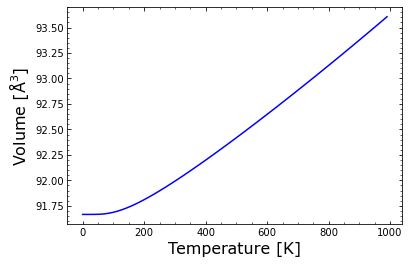

In [108]:
plt.xlabel("Temperature [K]", fontsize=16, fontfamily="Verdana")
plt.ylabel("Volume [Å$^3$]", fontsize=16, fontfamily="Verdana")
plt.plot(temperatures[:-1], volume_temperature, c="b");
plt.tick_params(which = "both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/volume_temperature.jpeg", dpi=300)

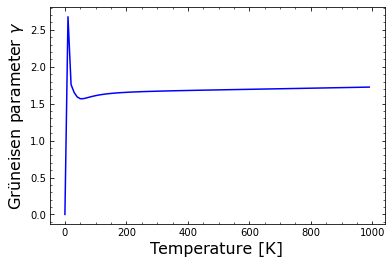

In [109]:
plt.xlabel("Temperature [K]", fontsize = 16, fontfamily = "Verdana")
plt.ylabel("Grüneisen parameter $\\gamma$", fontsize = 16, fontfamily = "Verdana")
plt.plot(temperatures[:-1], gruneisen_temperature, c="b")
plt.tick_params(which="both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/gruneisen_temperature.jpeg", dpi=300)

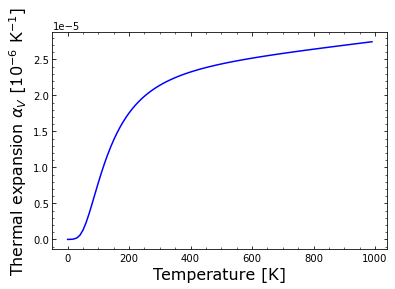

In [110]:
plt.xlabel("Temperature [K]", fontsize=16, fontfamily="Verdana")
plt.ylabel("Thermal expansion $\\alpha_V$ [10$^{-6}$ K$^{-1}$]", fontsize=16, fontfamily="Verdana")
plt.plot(temperatures[:-1], thermal_expansion, c="b")
plt.tick_params(which="both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/thermal_expansion.jpeg", dpi=300)

In [111]:
idx_300 = temperatures.tolist().index(300)
print("Volumetric thermal expansion at 300K: {}".format(thermal_expansion[idx_300]))
print("Linear thermal expansion at 300K: {}".format(thermal_expansion[idx_300]/3))

Volumetric thermal expansion at 300K: 2.141825462205965e-05
Linear thermal expansion at 300K: 7.139418207353216e-06


We can also include the dependence of electronic free energy on temperature. In this case the Helmholtz free energy of a crystal would be:<br><br>
$$F_{\text{QHA}} (T, V) = F_{\text{vib}} (T, V) + F_{\text{el}} (T, V),$$<br>
where $F_{\text{el}} (T, V) = U(V) + E_\text{el} (T, V) - E_{\text{el}} (0, V) - S_\text{el} (T,V) T$.
$E_\text{el} (T, V)$ and $S_\text{el} (T, V)$ can be approximated as follows:<br><br>
$$E_\text{el} (T, V) = g\sum f_i(V) \varepsilon_i (V),$$<br>
$$S_\text{el} (T, V) = -gk_B \sum f_i(V) \ln f_i(V) + (1-f_i(V))\ln(1-f_i(V)),$$<br>
where $g=1$ for collinear spin polarized and $g=2$ for non-spin polarized systems. Here
$\varepsilon_i$(V) is an energy of an $i$-th electronic eigenvalue and $f_i(V)$ is an occupation number according to Fermi-Dirac statistics:<br><br>
$$f_i(V) = \left\{ 1 + \exp \left[ \frac{\varepsilon_i(V) - \mu(V)}{k_B T} \right] \right\}^{-1},$$<br><br>
where $\mu(V)$ is a Fermi energy and can be found from the following condition on the number of electrons $N$:<br><br>
$$N = g\sum f_i(V).$$

In [112]:
free_energies_elec = []
for energy, vcell in zip(energies, vcells):
    with open(vcell.calc.directory + "/vasprun.xml", 'rb') as f:
        vxml = VasprunxmlExpat(f)
        vxml.parse()
    efe = ElectronFreeEnergy(vxml.eigenvalues[:, :, :, 0],
                             vxml.k_weights, vxml.NELECT)
    free_energies_elec_T = []
    for temperature in temperatures:
        efe.run(temperature)
        free_energies_elec_T.append(efe.free_energy)
        
    free_energies_elec.append(energy + np.array(free_energies_elec_T) - \
                              free_energies_elec_T[0])

In [113]:
qha_elec = PhonopyQHA(volumes, np.transpose(free_energies_elec), temperatures=temperatures, free_energy=np.transpose(free_energies),
                      cv=np.transpose(heat_capacities), entropy=np.transpose(entropies), eos='vinet')
helmholtz_volume_elec = np.array(qha_elec.get_helmholtz_volume())
thermal_expansion_elec = np.array(qha_elec.get_thermal_expansion())
volume_temperature_elec = np.array(qha_elec.get_volume_temperature())
gruneisen_temperature_elec = np.array(qha_elec.get_gruneisen_temperature())

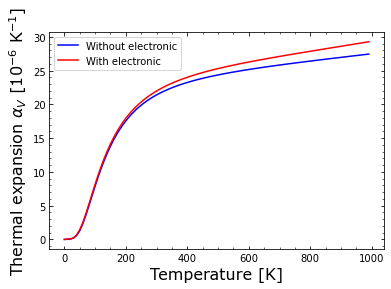

In [114]:
plt.xlabel("Temperature [K]", fontsize = 16, fontfamily = "Verdana")
plt.ylabel("Thermal expansion $\\alpha_V$ [10$^{-6}$ K$^{-1}$]", fontsize = 16, fontfamily = "Verdana")
plt.plot(temperatures[:-1], 1e6*thermal_expansion, c="b", label="Without electronic")
plt.plot(temperatures[:-1], 1e6*thermal_expansion_elec, c="r", label="With electronic")
plt.legend()
plt.tick_params(which="both", right=True, top=True, direction="in")
plt.minorticks_on()
# plt.savefig(PATH_PREFIX + "/final/thermal_expansion.jpeg", dpi=300)

In [115]:
idx_300 = temperatures.tolist().index(300)
print("Volumetric thermal expansion at 300K: {}".format(thermal_expansion_elec[idx_300]))
print("Linear thermal expansion at 300K: {}".format(thermal_expansion_elec[idx_300]/3))

Volumetric thermal expansion at 300K: 2.1996815684927792e-05
Linear thermal expansion at 300K: 7.332271894975931e-06


In [116]:
with open(PATH_PREFIX + "/final/thermal_expansion.dat", "w") as f:
    for coeff, temperature in zip(thermal_expansion_elec, temperatures[:-1]):
        f.write("{:.8f}\t{:.8f}\n".format(coeff*1e6, temperature))

In [117]:
with open(PATH_PREFIX + "/final/linear_thermal_expansion.dat", "w") as f:
    for coeff, temperature in zip(thermal_expansion_elec, temperatures[:-1]):
        f.write("{:.8f}\t{:.8f}\n".format(coeff*1e6/3, temperature))